In [336]:
!conda activate gymenv

In [337]:
import pandas as pd

Data loading and subject selection

In [338]:
from one.api import ONE

In [339]:
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Exception ignored in: <function One.__del__ at 0x0000013E88429580>
Traceback (most recent call last):
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\one\api.py", line 104, in __del__
    self.save_cache()
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\one\api.py", line 228, in save_cache
    parquet.save(filename, df, metadata)
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\iblutil\io\parquet.py", line 45, in save
    'one_metadata': json.dumps(metadata or {}).encode(),
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\json\__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\json\encoder.py", line 200, in encode
    chunks = self.iterencode(o, _one_shot=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Yash\anaconda3\envs\gymenv\Lib\json\encoder.py", line 258, in iteren

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [340]:
ids = one.search(task_protocol='biasedChoiceWorld')

In [341]:
id=ids[0]
trials= one.load_object(id, 'trials')

In [342]:
data = {}

for key in trials.keys():
    if trials[key].ndim == 1:
        data[key] = trials[key]

df = pd.DataFrame(data)

In [343]:
df.head()

,feedback_times,probabilityLeft,contrastLeft,feedbackType,goCue_times,stimOn_times,choice,rewardVolume,firstMovement_times,contrastRight,response_times
0,44.3375,0.5,NaN,-1.0,4.3596,NaN,1.0,0.0,44.008799,0.25,44.3080
1,49.4592,0.5,NaN,1.0,48.2709,48.2343,-1.0,1.5,49.212799,1.00,49.4591
2,53.5256,0.5,NaN,-1.0,53.3486,53.3175,1.0,0.0,53.262799,0.00,53.4814
3,57.7641,0.5,NaN,-1.0,56.9990,56.9674,1.0,0.0,57.131799,0.00,57.7335
4,64.1309,0.5,NaN,-1.0,62.4577,62.4259,1.0,0.0,63.624799,0.00,64.0981


In [344]:
df.describe()

,feedback_times,probabilityLeft,contrastLeft,feedbackType,goCue_times,stimOn_times,choice,rewardVolume,firstMovement_times,contrastRight,response_times
count,739.000000,739.000000,331.000000,739.000000,739.000000,738.000000,739.000000,739.000000,739.000000,408.000000,739.000000
mean,1707.484921,0.463058,0.261896,0.393775,1705.928072,1708.202855,0.171854,1.045332,1707.157119,0.299939,1707.474824
std,1011.972823,0.278890,0.353972,0.919829,1011.415538,1010.156170,0.985790,0.689872,1011.938885,0.386613,1011.972804
min,44.337500,0.200000,0.000000,-1.000000,4.359600,48.234300,-1.000000,0.000000,44.008799,0.000000,44.308000
25%,838.249050,0.200000,0.062500,-1.000000,837.968450,840.651250,-1.000000,0.000000,838.034299,0.062500,838.248950
50%,1689.088600,0.200000,0.125000,1.000000,1682.970700,1687.445800,1.000000,1.500000,1689.028799,0.125000,1689.088500
75%,2549.141299,0.800000,0.250000,1.000000,2547.509749,2548.844824,1.000000,1.500000,2548.995299,0.250000,2549.141199
max,3696.402899,0.800000,1.000000,1.000000,3678.015199,3677.983899,1.000000,1.500000,3696.201799,1.000000,3696.402799


Feature engineering and visualization

In [345]:
df['action_time']=df['response_times']-df['firstMovement_times']  #action_time=time taken by mouse to respond after it starts movement
df['action_time'].describe()

count    739.000000
mean       0.317704
std        1.041533
min        0.057901
25%        0.152901
50%        0.208300
75%        0.260801
max       25.978800
Name: action_time, dtype: float64

In [346]:
df['trial_interval']=df['goCue_times'].shift(-1)-df['feedback_times']  #trial_interval=time interval between two consecutive trials
df['trial_interval'].describe()

count    738.000000
mean       3.443810
std        0.679145
min        2.480200
25%        2.867925
50%        3.246200
75%        3.916425
max        6.273700
Name: trial_interval, dtype: float64

In [347]:
exclude_columns = [
    'rewardVolume', 'firstMovement_times', 'response_times',
    'probabilityLeft', 'contrastLeft', 'stimOn_times', 'contrastRight', 'choice']  #removing columns that have similar meaning with others or unwanted one
df2=df.drop(columns=exclude_columns)

Normalising fields

In [348]:
min_ft_val=df2['feedback_times'].min()
max_ft_val=df2['feedback_times'].max()

min_at_val=df2['action_time'].min()
max_at_val=df2['action_time'].max()

min_ti_val=df2['trial_interval'].min()
max_ti_val=df2['trial_interval'].max()

In [349]:
df3=df2.copy()

In [350]:
#Normalising fields in range between 0-1

df3['feedback_times']=(df2['feedback_times']-min_ft_val)/(max_ft_val-min_ft_val)
df3['feedback_times']=(df2['feedback_times']-min_ft_val)/(max_ft_val-min_ft_val)

df3['action_time']=(df2['action_time']-min_at_val)/(max_at_val-min_at_val)
df3['action_time']=(df2['action_time']-min_at_val)/(max_at_val-min_at_val)

df3['trial_interval']=(df2['trial_interval']-min_ti_val)/(max_ti_val-min_ti_val)
df3['trial_interval']=(df2['trial_interval']-min_ti_val)/(max_ti_val-min_ti_val)

df3['feedback_times']=df3['feedback_times'].diff()  #feedback time in perticular trial
df3['feedback_times']=df3['feedback_times'].diff().fillna(0)
df3['feedback_times']=df3['feedback_times']*100

df3['feedbackType']=df2['feedbackType']

In [351]:
df3 = df3[df3['feedback_times'] >= 0]  #removing the rows that have some ambiguity

In [352]:
df3.head()

,feedback_times,feedbackType,goCue_times,action_time,trial_interval
0,0.000000,-1.0,4.3596,0.009309,0.383076
1,0.000000,1.0,48.2709,0.007268,0.371478
3,0.004712,-1.0,56.9990,0.020979,0.583472
4,0.058277,-1.0,62.4577,0.016026,0.402083
5,0.055426,-1.0,68.1364,0.112654,0.647792


In [353]:
df3.to_csv('trials.csv', index=False)

Boredom score computation and plotting

In [354]:
df3.describe()

,feedback_times,feedbackType,goCue_times,action_time,trial_interval
count,357.000000,357.000000,357.000000,357.000000,356.000000
mean,0.050433,0.327731,1717.482153,0.014082,0.264932
std,0.066663,0.946097,1013.495869,0.057418,0.182268
min,0.000000,-1.000000,4.359600,0.000000,0.000659
25%,0.015515,-1.000000,846.866500,0.003569,0.107704
50%,0.030358,1.000000,1717.929900,0.005949,0.216713
75%,0.064333,1.000000,2556.170299,0.008325,0.396481
max,0.825976,1.000000,3678.015199,1.000000,0.934124


In [355]:
df3['feedback_penalty'] = df3['feedbackType'].map({1: 0, -1: 0.5, 0: 1}) #feedbackType is mapped with positive values

#creating mathematical expression for Boredom Score
#boredom can mainly defined by feedback_times because mouse will take a long time to respond if its bored
#action_time and trial_interval can have similar weightage

df3['boredom_score']=df3['feedback_times']*0.4 + df3['action_time']*0.25 + df3['trial_interval']*0.25 + df3['feedback_penalty']*0.1

In [356]:
df3.head()

,feedback_times,feedbackType,goCue_times,action_time,trial_interval,feedback_penalty,boredom_score
0,0.000000,-1.0,4.3596,0.009309,0.383076,0.5,0.148096
1,0.000000,1.0,48.2709,0.007268,0.371478,0.0,0.094686
3,0.004712,-1.0,56.9990,0.020979,0.583472,0.5,0.202998
4,0.058277,-1.0,62.4577,0.016026,0.402083,0.5,0.177838
5,0.055426,-1.0,68.1364,0.112654,0.647792,0.5,0.262282


In [357]:
df3.describe()

,feedback_times,feedbackType,goCue_times,action_time,trial_interval,feedback_penalty,boredom_score
count,357.000000,357.000000,357.000000,357.000000,356.000000,357.000000,356.000000
mean,0.050433,0.327731,1717.482153,0.014082,0.264932,0.168067,0.106387
std,0.066663,0.946097,1013.495869,0.057418,0.182268,0.236524,0.075760
min,0.000000,-1.000000,4.359600,0.000000,0.000659,0.000000,0.002298
25%,0.015515,-1.000000,846.866500,0.003569,0.107704,0.000000,0.039762
50%,0.030358,1.000000,1717.929900,0.005949,0.216713,0.000000,0.089830
75%,0.064333,1.000000,2556.170299,0.008325,0.396481,0.500000,0.163426
max,0.825976,1.000000,3678.015199,1.000000,0.934124,0.500000,0.659658


In [358]:
import matplotlib.pyplot as plt

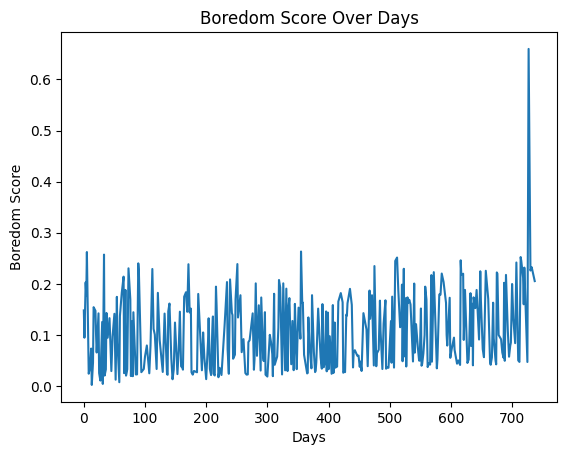

In [359]:
plt.plot(df3.index, df3['boredom_score'])
plt.title('Boredom Score Over Days')
plt.xlabel('Days')
plt.ylabel('Boredom Score')
plt.show()

Model architecture and training

In [360]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

In [361]:
X = df3[['feedback_times', 'action_time', 'trial_interval']]
y = df3['boredom_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [362]:
X_train_feedback = X_train[['feedback_times']]
X_train_action = X_train[['action_time']]
X_train_interval = X_train[['trial_interval']]

In [363]:
def clean_nan(X, y):  #there were some NA values in the dataset which is causing an error , that's why using this function
    df = X.copy()
    df['target'] = y
    df = df.dropna()
    return df.drop(columns='target'), df['target']

X_train_feedback, y_clean = clean_nan(X_train_feedback, y_train)
X_train_action, y_clean = clean_nan(X_train_action, y_clean)
X_train_interval, y_clean = clean_nan(X_train_interval, y_clean)

In [364]:
model=LinearRegression()
model_feedback = model.fit(X_train_feedback, y_clean)
model_action = model.fit(X_train_action, y_clean)
model_interval=model.fit(X_train_interval, y_clean)

In [365]:
x_feedback_line = np.linspace(X_train_feedback.min(), X_train_feedback.max(), 100).reshape(-1, 1)
x_action_line = np.linspace(X_train_action.min(), X_train_action.max(), 100).reshape(-1, 1)
x_interval_line = np.linspace(X_train_interval.min(), X_train_interval.max(), 100).reshape(-1, 1)

In [366]:
y_feedback_line = model_feedback.predict(x_feedback_line)
y_action_line = model_action.predict(x_action_line)
y_interval_line = model_action.predict(x_interval_line)

c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Yash\anaconda3\envs\gymenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Plots showing score trends, prediction error, model behavior across sessions

<function matplotlib.pyplot.show(close=None, block=None)>

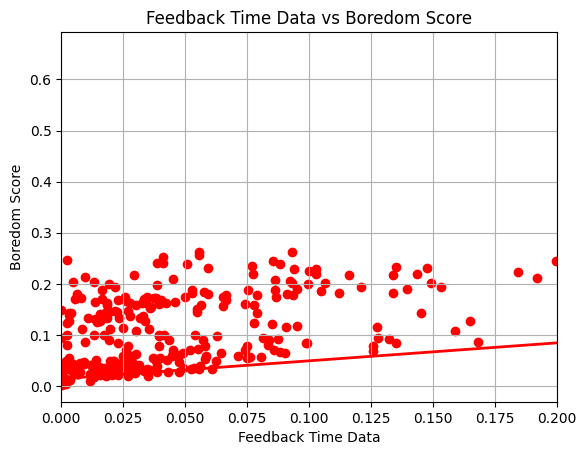

In [367]:
#plotting graph for Feedback Time Data vs Boredom Score

plt.scatter(X_train_feedback, y_clean, color='red')
plt.plot(x_feedback_line, y_feedback_line, color='red', linewidth=2)
plt.title('Feedback Time Data vs Boredom Score')
plt.xlabel('Feedback Time Data')
plt.ylabel('Boredom Score')
plt.grid()
plt.xlim(0, 0.2)
plt.show

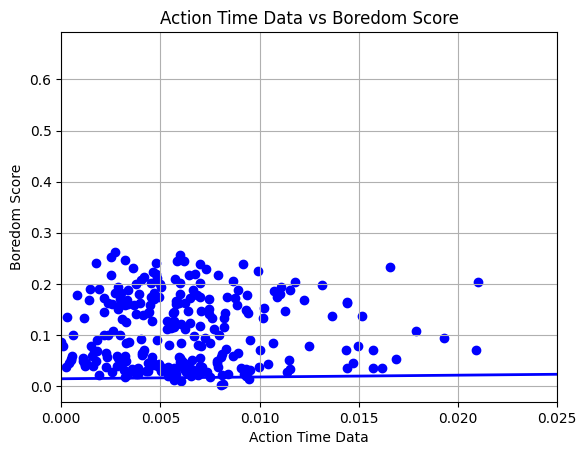

In [368]:
#plotting graph for Action Time Data vs Boredom Score

plt.scatter(X_train_action, y_clean, color='blue', label='Action Time Data')
plt.plot(x_action_line, y_action_line, color='blue', linewidth=2, label='Action Time Regression')
plt.title('Action Time Data vs Boredom Score')
plt.xlabel('Action Time Data')
plt.ylabel('Boredom Score')
plt.grid()
plt.xlim(0,0.025)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

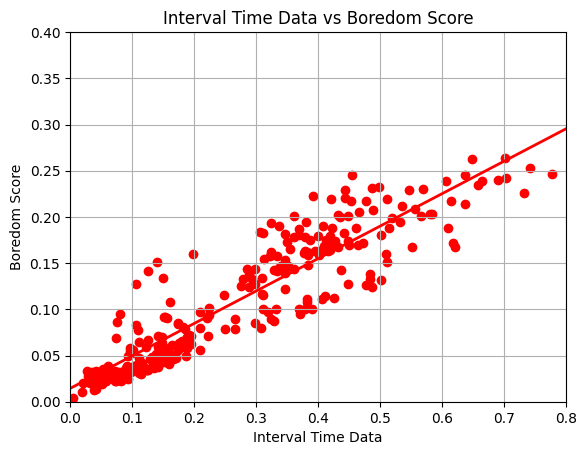

In [369]:
#plotting graph for Interval Time Data vs Boredom Score

plt.scatter(X_train_interval, y_clean, color='red')
plt.plot(x_interval_line, y_interval_line, color='red', linewidth=2)
plt.title('Interval Time Data vs Boredom Score')
plt.xlabel('Interval Time Data')
plt.ylabel('Boredom Score')
plt.grid()
plt.xlim(0,0.8)
plt.ylim(0,0.4)
plt.show

In [370]:
X_test = X_test.dropna() #removing NA values from dataset
y_test = y_test.loc[X_test.index]

model.fit(X_test, y_test)

y_pred = model.predict(X_test)

Finding Mean Absolute Error

In [371]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) on test data: {mae:.2f}")

Mean Absolute Error (MAE) on test data: 0.01


Plotting Actual vs Predicted Boredom Scores

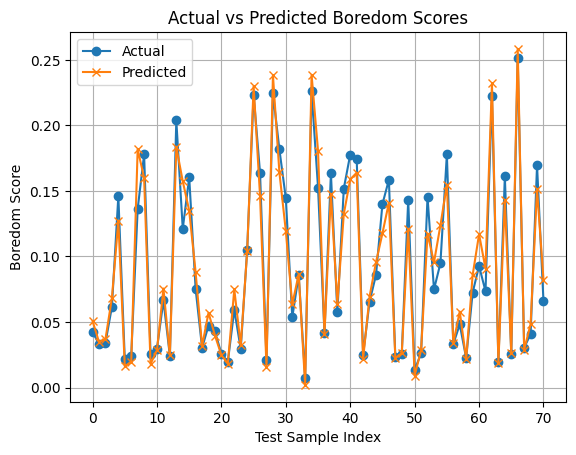

In [372]:
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Boredom Scores')
plt.xlabel('Test Sample Index')
plt.ylabel('Boredom Score')
plt.legend()
plt.grid()
plt.show()